In [30]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd 
import numpy as np
from tqdm import tqdm
import pickle
import os

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from mlxtend.plotting import plot_confusion_matrix

import warnings
warnings.filterwarnings("ignore")

from drive.MyDrive.Quora_Duplicate_Questions.src.functions import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
set_seed(69)

PATH = 'drive/MyDrive/Quora_Duplicate_Questions/'
data = pd.read_csv(PATH+'src/data_engineered.csv', index_col='id')

fs1 = ['q1_len', 'q2_len', 'len_difference', 'len_abs_difference',
       'q1_char_len', 'q2_char_len', 'q1_num_words', 'q2_num_words',
       'q1_freq', 'q2_freq', 'total_freq', 'abs_diff_freq', 
        'num_common_words', 'ratio_common_words']

fs2 = ['fuzz_qratio', 'fuzz_Wratio', 'fuzz_partial_ratio', 
       'fuzz_partial_token_set_ratio', 'fuzz_partial_token_sort_ratio',
       'fuzz_token_set_ratio', 'fuzz_token_sort_ratio']

fs3_1 = get_pickle('fs3_1')
fs3_2 = get_pickle('fs3_2')
fs3_3 = get_pickle('fs3_3')
fs3_4 = get_pickle('fs3_4')
fs3_5 = get_pickle('fs3_5')

fs4_1 = ['cosine_distance', 'cityblock_distance', 
         'jaccard_distance', 'canberra_distance', 
         'euclidean_distance', 'minkowski_distance',
         'braycurtis_distance']

fs4_2 = ['wmd', 'norm_wmd']

w2v = get_pickle('w2v')

In [14]:
scaler = StandardScaler()
y = data.is_duplicate.values
y = y.astype('float32').reshape(-1, 1)
X = data[fs1+fs2+fs4_1+fs4_2]
X = X.replace([np.inf, -np.inf], np.nan).fillna(0).values
X = scaler.fit_transform(X)
X = np.hstack((X, fs3_3, fs3_4, w2v))

In [15]:
n_all = y.shape[0]
idx = np.arange(n_all)
np.random.shuffle(idx)
n_split = n_all // 10
idx_val = idx[:n_split]
idx_train = idx[n_split:]
x_train = X[idx_train]
y_train = np.ravel(y[idx_train])
x_val = X[idx_val]
y_val = np.ravel(y[idx_val])

In [ ]:
logres = LogisticRegression(
    max_iter=1000
    )
params = {
    'C': [0.01, 0.1, 0.5, 1, 5]
}
search = GridSearchCV(logres, params, cv=5, verbose=1, return_train_score=True)

search.fit(x_train, y_train)
lr_preds = search.predict(x_val)
print(classification_report(y_val, lr_preds))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcddc99ab50>)

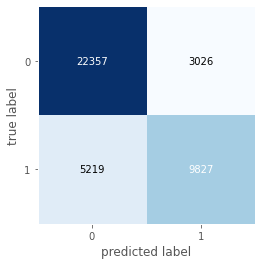

In [17]:
plot_confusion_matrix(confusion_matrix(y_val, lr_preds))

LogisticRegression(C=0.1, max_iter=1000)
               precision    recall  f1-score   support

         0.0       0.81      0.88      0.84     25383
         1.0       0.76      0.65      0.70     15046

    accuracy                           0.80     40429
   macro avg       0.79      0.77      0.77     40429
weighted avg       0.79      0.80      0.79     40429



AttributeError: ignored

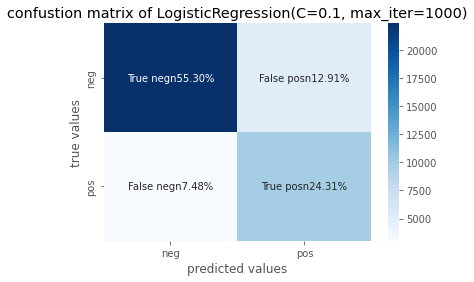

In [26]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
def scr(clf, d_val, ytrue):
        y_pred = (clf.predict(d_val) >= 0.5).astype(int)
        cm = confusion_matrix(y_pred, ytrue)
        cats = ['neg', 'pos']
        groups = ['True neg', 'False pos', 'False neg', 'True pos']
        group_percents = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
        labels = [f'{v1}n{v2}' for v1, v2 in zip(groups, group_percents)]
        labels = np.asarray(labels).reshape(2, 2)
        sns.heatmap(cm, annot=labels, cmap='Blues', xticklabels=cats, yticklabels=cats, fmt='')
        plt.xlabel('predicted values')
        plt.ylabel('true values')
        plt.title(f'confustion matrix of {clf}')
        print(f'{clf}\n', classification_report(d_val, y_pred))
        print(f'best params: {clf.best_params_}, score: {clf.score(d_val)}')
scr(search, x_val, y_val)
#print(classification_report(xgb_preds, y_val))

In [28]:
logres.coef_

array([[-4.68008854e-01, -2.49493010e-01, -1.70839949e-01,
         2.98011382e-01, -1.95714248e-02,  3.07580210e-02,
         3.39910454e-01, -3.67761683e-01,  1.34148853e+00,
         1.48836010e+00,  1.64886833e+00, -2.41343565e+00,
         7.24824355e-02,  2.23464076e-01,  9.32520258e-02,
        -2.85663285e-01, -9.54577494e-02,  1.11128727e+00,
        -1.33985875e-03,  5.34683581e-01,  3.24033711e-01,
        -1.17664340e+00,  7.53662056e-01, -1.47241711e-01,
         1.54385540e-01,  5.82242812e-01, -1.47552481e-01,
        -9.09393547e-01, -9.62801215e-01,  1.07489281e+00,
        -3.50206981e-03,  9.03798509e-03,  3.57099118e-01,
        -5.86192863e-01, -2.25115293e-01,  4.08999966e-01,
         1.12550515e-02, -1.05963831e-02,  1.64231648e-03,
         3.78812509e-02,  1.52083806e-01, -2.85295407e-01,
        -1.22516575e-01,  7.13719103e-01,  2.63374681e-02,
         7.22863293e-02, -1.05783603e-03,  3.33190836e-02,
         1.93697653e-02,  7.45370400e-03,  3.60603278e-0